# Transitioning to autonomous driving: <br>Mixed vehicle autonomy levels on freeways
### Notebook to analyse simulation warm-up time.

Jesse Poland<br>
TU Delft<br>
Date: 02-10-2024<br>

### 0. Python packages and loading data files

First, Python packages are imported to provide specific functionalities within the notebook. Then, the file paths are set to retrieve stored simulation data for all experiment runs and seeds. The simulation data is loaded into Pandas DataFrames, making the data ready for analysis.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from IPython.display import display
import zipfile

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_rows', None)

In [2]:
# simulation output folder
experiment_name = 'explore_demand_3'

# load Java simulation data
experiment_folder = fr'F:\jesse_sim_results\{experiment_name}'
# experiment_folder = fr'data\{experiment_name}'

# available files
input_values = 'inputValues.csv'
intermediate_output = 'intermediateOutputData.csv'
single_output = 'singleOutputData.csv'
sequence_output = 'sequenceOutputData.csv'
lane_change_output = 'laneChangeOutputData.csv'

In [3]:
# function to get a list of all file/folder names within a folder
def get_file_names(path):
    return os.listdir(path)

# load available seed folders
seed_folders = get_file_names(experiment_folder)

In [4]:
# function to retrieve any data within the project folder as dataframe
def load_dataframe(columns_of_interest, folder, file, input_file=None):
    # create empty DataFrame
    df = pd.DataFrame()
    
    # loop through all seed folders from this experiment
    for seed_name in get_file_names(folder):
        # get all runs within this experiment
        run_folders = get_file_names(os.path.join(folder, seed_name))

        # go through all runs
        for run_folder in run_folders:
            run_number = int(run_folder.split('_')[1])
            data_folder = os.path.join(folder, seed_name, run_folder)

            # open zip file (remove .csv form file name)
            try:
                with zipfile.ZipFile(os.path.join(data_folder, fr'{file[:-4]}.zip'), 'r') as zip_ref:
                    # read sequence csv
                    with zip_ref.open(file) as data_file:
                        df_run = pd.read_csv(data_file)
                        df_interest = df_run[columns_of_interest].copy()
                        df_interest['run'] = run_number
                # add input values to the dataframe if the input file is specified
                if input_file is not None:
                    # open input zip file
                    with zipfile.ZipFile(os.path.join(data_folder, fr'{input_file[:-4]}.zip'), 'r') as zip_ref:
                        # read input csv
                        with zip_ref.open(input_file) as input_data_file:
                            df_input = pd.read_csv(input_data_file)
                    # broadcast input data to all rows in df_interest
                    for col in df_input.columns:
                        df_interest[col] = df_input[col].iloc[0]
    
                # add this data to the main DataFrame
                df = pd.concat([df, df_interest])
            except:
                print(f'An error occured when trying to read data from: {data_folder}. This folder may contain a BadZipFile.')
    
    # return resulting DataFrame
    df.reset_index(drop=True, inplace=True)
    return df
    

### 1. Analyse FD data
The freeway layout is chosen because of the bottleneck of the on-ramp. This should create disruptions to traffic which forces vehicles to change lanes and bring variety to car-following. Because of this, the bottleneck section of the freeway is analysed. Link BC contains the two main freeway lanes and the merging lane of the on-ramp: BC.LEFT, BC.RIGHT, and BC.ONRAMP.

The exploratory runs are performed for a range of demand values:
- Main demand: 2000 - 5000 vehicles/hour
- Ramp demand: 200 - 1000 vehicles/hour

These ranges were chosen because the exploratory runs should contain both free-flow and congested traffic to analyse for which demand ranges traffic will be near its critical capacity limit. This critical capacity is important to simulate because these are the scenarios where different mixes of vehicle types will influence the road capacity and thus show the effects on traffic performance.

To analyse the improvements that vehicle automation features could bring for traffic performance, the following penetration rates are used for this "base" scenario:
- Level 0: 100%
- Level 1: 0%
- Level 2: 0%
- Level 3: 0%

In [5]:
######
# CD lanes? BC lanes? etc. each their own notebook and compare?
# scopus: Are critical density data points always scarse?

# Step 1: Show all intermediate data points to show the critical density and capacity droop? FD: flow vs density, speed vs density, flow vs speed.

# Step 2: Show individual runs and discuss how much free-flow, saturated, and congested flow there is.

# Step 3: How does this compare against mean values?

# Step 4: Determine a way to identify free, saturated and congested flow, use values identified in step 1?

# Step 5: Better representation of near critical density flow by adjusting ramp and main demand?

In [6]:
# show scatter plot
def show_fd_scatter_plot_seeds(df, density_var, flow_var):
    # get seeds
    seeds = df['seed'].unique()

    # categorical colors for runs
    categorical_colors = [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 
        'blue', 'darkorange', 'forestgreen', 'crimson', 'indigo',
        'saddlebrown', 'hotpink', 'dimgray', 'yellowgreen', 'deepskyblue',
        'slateblue', 'coral', 'lightseagreen', 'gold', 'orchid',
        'mediumslateblue', 'darkgoldenrod', 'lightcoral', 'royalblue', 'mediumvioletred',
        'darkkhaki', 'mediumaquamarine', 'darkturquoise', 'lightpink', 'teal',
        'rosybrown', 'mediumblue', 'peru', 'slategray', 'mediumorchid'
    ]

    # get color per run
    unique_runs = df['run'].unique()
    run_to_color = {run: color for run, color in zip(unique_runs, categorical_colors)}

    # create plots for seeds
    n_columns = 4
    n_rows = (len(seeds) + n_columns - 1) // n_columns
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(24, n_rows * 3))
    axes = axes.flatten()
    
    # loop through each seed
    for i, seed in enumerate(seeds):
        # get seed
        df_seed = df[df['seed'] == seed]

        # map colors based on run
        df_seed_colors = df_seed['run'].map(run_to_color)
        
        # plot seed data
        axes[i].scatter(df_seed[density_var], df_seed[flow_var], color=df_seed_colors, alpha=0.7)
        axes[i].set_xlabel('Density [veh/km]')
        axes[i].set_ylabel('Flow [veh/h]')
        axes[i].set_title(f'Fundamental diagram section {density_var.split("_")[0]} for seed {seed}')
        
    # hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # show plots
    plt.tight_layout()
    plt.show()

def show_fd_scatter_plot_runs(df, density_var, flow_var):
    # get all runs
    runs = df['run'].unique()

    # create plots for all runs
    n_columns = 2
    n_rows = (len(runs) + n_columns - 1) // n_columns
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(14, n_rows * 3))
    axes = axes.flatten()
    
    # print each seed seperately
    for i, run in enumerate(runs):
        # get run
        df_run = df[df['run'] == run]
        
        # plot figure
        scatter = axes[i].scatter(df_run[density_var], df_run[flow_var], c=df_run['time'], cmap='viridis')
        axes[i].set_xlabel('Density [veh/km]')
        axes[i].set_ylabel('Flow [veh/h]')
        axes[i].set_title(f'Fundamental diagram section {density_var.split("_")[0]} for run {run}')

        # set color bar
        fig.colorbar(scatter, ax=axes[i], label='Time [s]')
    
    # hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # show plots
    plt.tight_layout()
    plt.show()


def show_fd_scatter_plot_sections(df, sections):
    # create plots for all sections
    n_columns = 2
    n_rows = (len(sections) + n_columns - 1) // n_columns
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(12, n_rows * 3))
    axes = axes.flatten()
    
    # print each seed seperately
    for i, section in enumerate(sections):
        
        # plot figure
        scatter = axes[i].scatter(df[f'{section}_density'], df[f'{section}_flow'], c=df['time'], cmap='viridis')
        axes[i].set_xlabel('Density [veh/km]')
        axes[i].set_ylabel('Flow [veh/h]')
        axes[i].set_title(f'Fundamental diagram for road section: {section}')

        # set color bar
        fig.colorbar(scatter, ax=axes[i], label='Time [s]')
    
    # hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # show plots
    plt.tight_layout()
    plt.show()


# add time column
def add_time_column(df, sample_interval):
    df['time'] = df.groupby(['seed', 'run']).cumcount() * sample_interval
    return df

# filter columns
def filter_columns(df, selected_variables):
    columns_to_include = [col for col in df.columns if col in selected_variables]
    df = df[columns_to_include]
    return df

# convert data
def convert_fd_data(df):
    df_converted = df.copy()
    for col in df_converted.columns.tolist():
        if 'flow' in col:
            df_converted[col] = df_converted[col].astype(float) * 3600
        if 'density' in col:
            df_converted[col] = df_converted[col].astype(float) * 1000
        if 'speed' in col:
            df_converted[col] = df_converted[col].astype(float) * 3.6
    return df_converted

In [7]:
# select merging lanes and required FD variables
variables = ['AB.LEFT_density', 'AB.LEFT_flow', 'AB.LEFT_speed',
             'AB.RIGHT_density', 'AB.RIGHT_flow', 'AB.RIGHT_speed',
             'BC.LEFT_density', 'BC.LEFT_flow', 'BC.LEFT_speed',
             'BC.RIGHT_density', 'BC.RIGHT_flow', 'BC.RIGHT_speed',
             'BC.ONRAMP_density', 'BC.ONRAMP_flow', 'BC.ONRAMP_speed',
             'CD.LEFT_density', 'CD.LEFT_flow', 'CD.LEFT_speed',
             'CD.RIGHT_density', 'CD.RIGHT_flow', 'CD.RIGHT_speed',
             'E2B.ONRAMP_density', 'E2B.ONRAMP_flow', 'E2B.ONRAMP_speed'
            ]

# get intermediate FD data
df_fd = load_dataframe(variables, experiment_folder, intermediate_output, input_values)
# remove empty rows (these exist because other variables are also stored in the intermediate CSV)
# flow variable is always 0, so NaN value indicates that no data was recorded at all
df_fd = df_fd.dropna(subset=['BC.RIGHT_flow'])
# add time column, each FD calculation represents 30 sec
df_fd = add_time_column(df_fd, 30)
# select columns of interest
variables_of_interest = ['time', 'seed', 'run', 'main_demand', 'ramp_demand'] + variables
df_fd = filter_columns(df_fd, variables_of_interest)
# remove warm-up time
df_fd = df_fd[df_fd['time'] >= 500]

display(df_fd.head(10))

,AB.LEFT_density,AB.LEFT_flow,AB.LEFT_speed,AB.RIGHT_density,AB.RIGHT_flow,AB.RIGHT_speed,BC.LEFT_density,BC.LEFT_flow,BC.LEFT_speed,BC.RIGHT_density,...,CD.RIGHT_flow,CD.RIGHT_speed,E2B.ONRAMP_density,E2B.ONRAMP_flow,E2B.ONRAMP_speed,run,seed,main_demand,ramp_demand,time
17,0.026658,0.527738,19.796778,0.061484,0.298004,4.846859,0.030624,0.597798,19.520558,0.038972,...,0.543302,24.123358,0.136737,0.041834,0.305942,0,0,3706.896172,911.05643,510
18,0.025127,0.505283,20.108939,0.060484,0.377131,6.235201,0.028688,0.523326,18.241903,0.059191,...,0.500205,23.537644,NaN,0.000000,0.000000,0,0,3706.896172,911.05643,540
19,0.026658,0.559929,21.004279,0.060624,0.371653,6.130449,0.029181,0.572627,19.623395,0.079480,...,0.407585,22.612513,0.144786,0.014637,0.101092,0,0,3706.896172,911.05643,570
20,0.028556,0.590150,20.666730,0.060876,0.396589,6.514655,0.024376,0.562487,23.075603,0.058331,...,0.490229,26.130091,0.135097,0.047010,0.347971,0,0,3706.896172,911.05643,600
21,0.030117,0.601850,19.983948,0.063659,0.407979,6.408775,0.025211,0.576214,22.855639,0.047548,...,0.477267,27.100982,0.135097,0.047019,0.348039,0,0,3706.896172,911.05643,630
22,0.031114,0.605516,19.461199,0.067190,0.421479,6.272930,0.025895,0.584719,22.580548,0.038627,...,0.522722,26.343835,0.135097,0.046836,0.346687,0,0,3706.896172,911.05643,660
23,0.028217,0.549079,19.459480,0.061265,0.371162,6.058287,0.028623,0.594806,20.780794,0.039513,...,0.511739,25.399240,0.143838,0.016557,0.115106,0,0,3706.896172,911.05643,690
24,0.027548,0.552264,20.047651,0.056352,0.408525,7.249493,0.029494,0.583125,19.771154,0.036182,...,0.530111,25.244471,NaN,0.000000,0.000000,0,0,3706.896172,911.05643,720
25,0.028585,0.590148,20.645654,0.047205,0.512045,10.847144,0.029382,0.568146,19.336313,0.035616,...,0.510466,24.153048,0.145864,0.010550,0.072331,0,0,3706.896172,911.05643,750
26,0.029530,0.595707,20.172846,0.042389,0.510174,12.035558,0.030480,0.588208,19.298441,0.044713,...,0.488556,22.685839,0.139880,0.030704,0.219502,0,0,3706.896172,911.05643,780


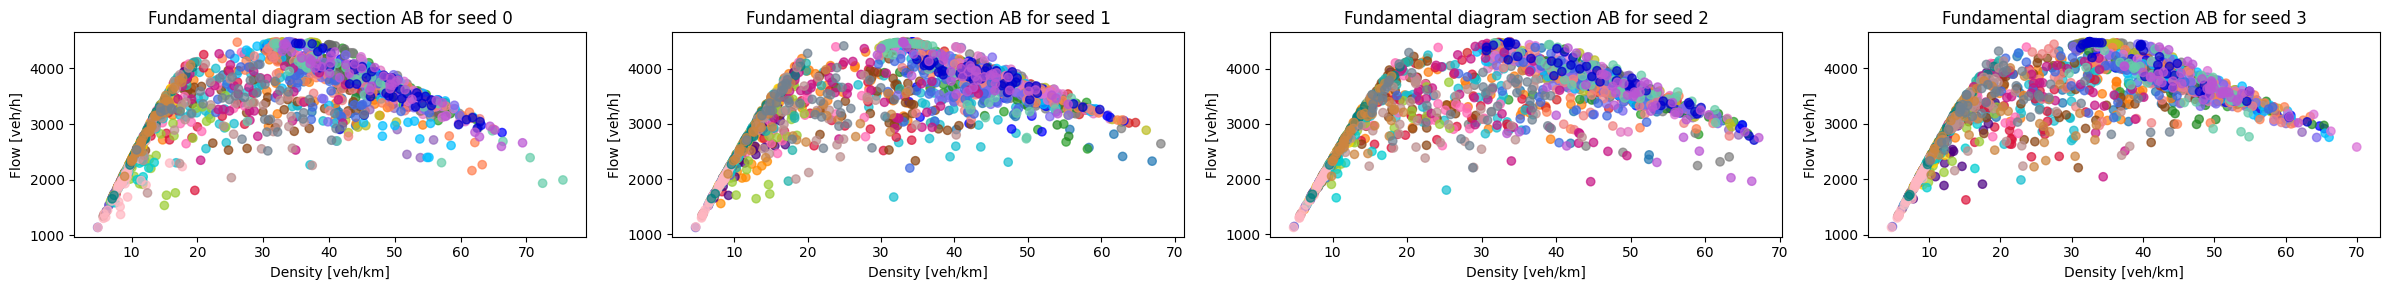

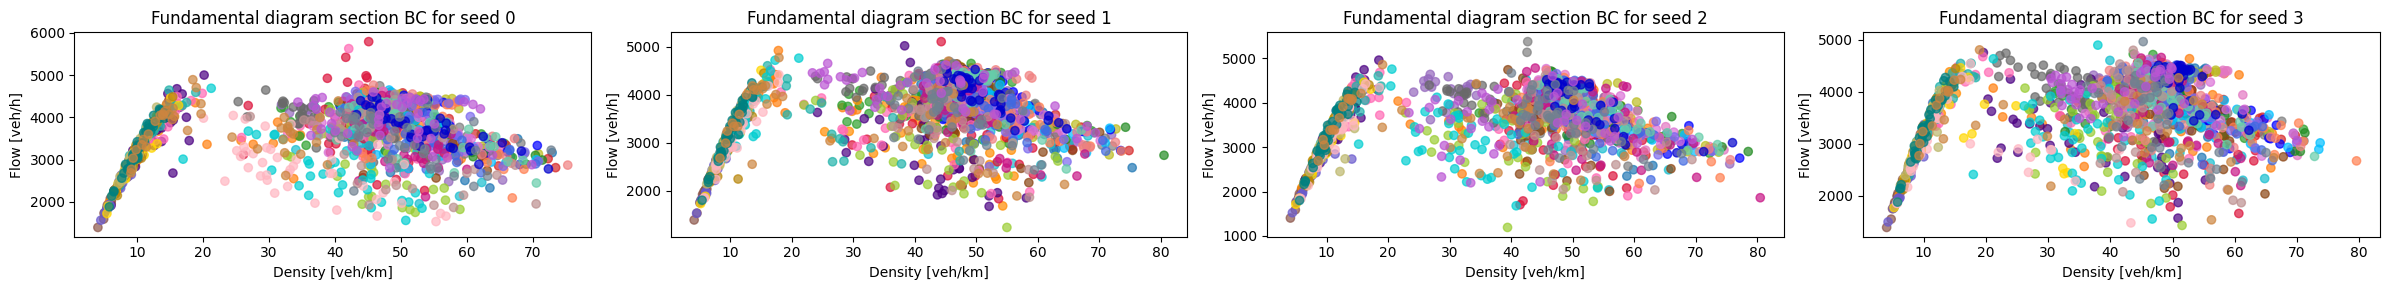

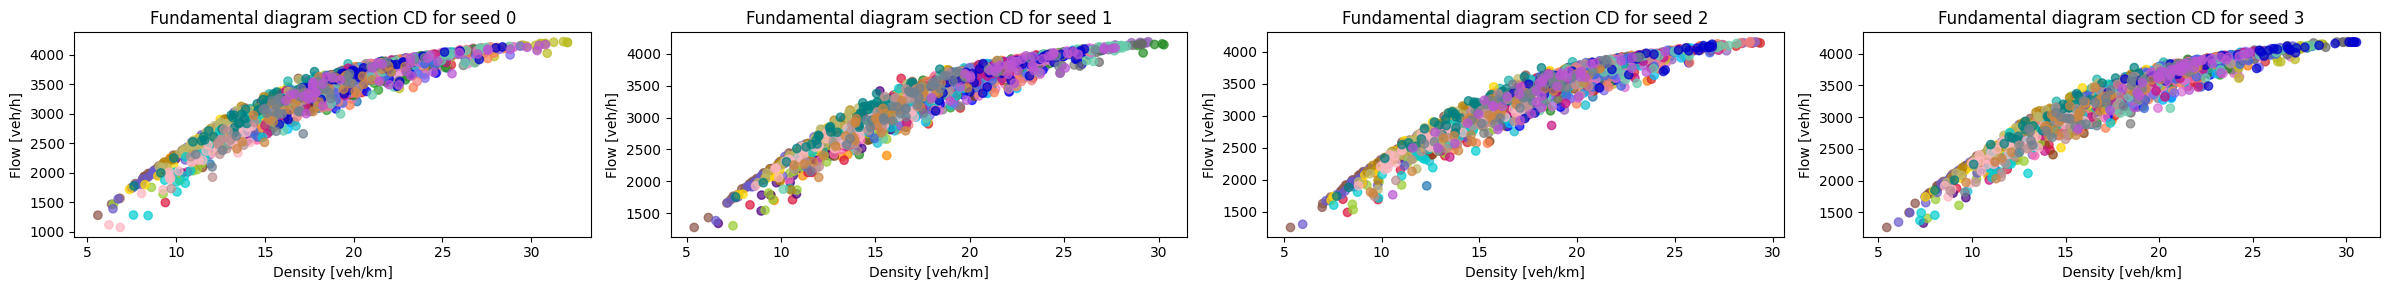

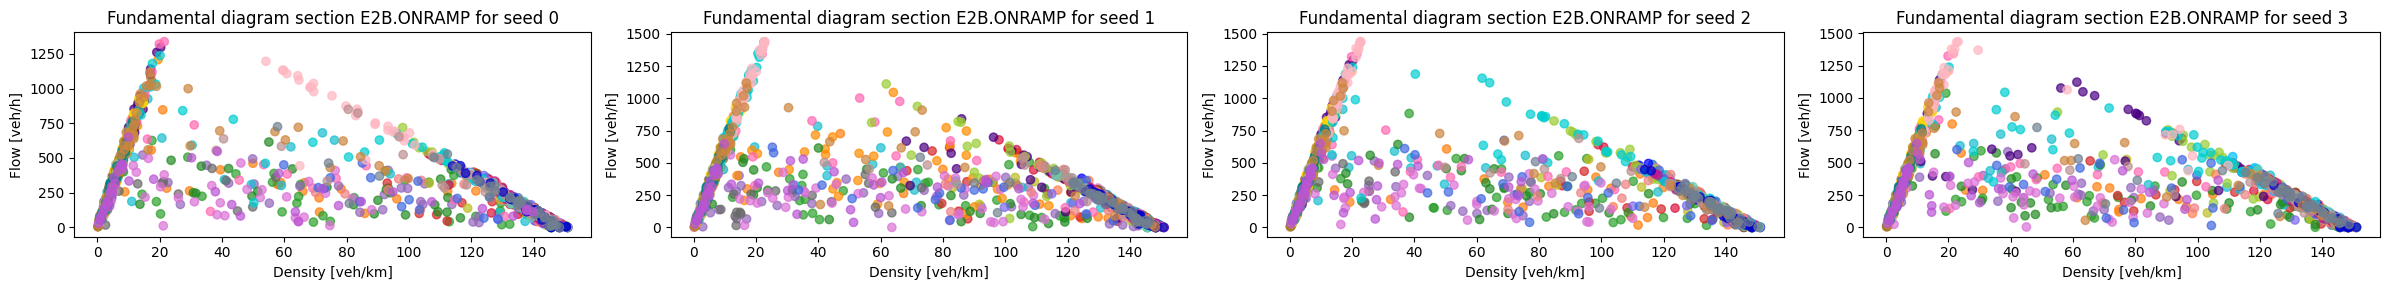

In [8]:
# combine road areas
df_fd_combined = pd.DataFrame()
# get run info
df_fd_combined['time'] = df_fd['time']
df_fd_combined['main_demand'] = df_fd['main_demand']
df_fd_combined['ramp_demand'] = df_fd['ramp_demand']
df_fd_combined['seed'] = df_fd['seed']
df_fd_combined['run'] = df_fd['run']
# create AB section (main lanes pre-merging)
df_fd_combined['AB_flow'] = df_fd['AB.LEFT_flow'] + df_fd['AB.RIGHT_flow']
df_fd_combined['AB_density'] = (df_fd['AB.LEFT_density'] + df_fd['AB.RIGHT_density']) / 2
df_fd_combined['AB_speed'] = (df_fd['AB.LEFT_speed'] + df_fd['AB.RIGHT_speed']) / 2
# create BC section (main lanes + merging lane)
df_fd_combined['BC_flow'] = df_fd['BC.LEFT_flow'] + df_fd['BC.RIGHT_flow'] + df_fd['BC.ONRAMP_flow']
df_fd_combined['BC_density'] = (df_fd['BC.LEFT_density'] + df_fd['BC.RIGHT_density'] + df_fd['BC.ONRAMP_density']) / 3
df_fd_combined['BC_speed'] = (df_fd['BC.LEFT_speed'] + df_fd['BC.RIGHT_speed'] + df_fd['BC.ONRAMP_speed']) / 3
# create CD section (main lanes post-merging)
df_fd_combined['CD_flow'] = df_fd['CD.LEFT_flow'] + df_fd['CD.RIGHT_flow']
df_fd_combined['CD_density'] = (df_fd['CD.LEFT_density'] + df_fd['CD.RIGHT_density']) / 2
df_fd_combined['CD_speed'] = (df_fd['CD.LEFT_speed'] + df_fd['CD.RIGHT_speed']) / 2
# also include onramp lane
df_fd_combined['E2B.ONRAMP_flow'] = df_fd['E2B.ONRAMP_flow']
df_fd_combined['E2B.ONRAMP_density'] = df_fd['E2B.ONRAMP_density']
df_fd_combined['E2B.ONRAMP_speed'] = df_fd['E2B.ONRAMP_speed']
    
df_new_fd = convert_fd_data(df_fd_combined)
show_fd_scatter_plot_seeds(df_new_fd, 'AB_density', 'AB_flow')
show_fd_scatter_plot_seeds(df_new_fd, 'BC_density', 'BC_flow')
show_fd_scatter_plot_seeds(df_new_fd, 'CD_density', 'CD_flow')
show_fd_scatter_plot_seeds(df_new_fd, 'E2B.ONRAMP_density', 'E2B.ONRAMP_flow')

<b>What do we observe?</b>

No significant differences are observed between seed values. Therefore, the fundamental diagrams are analysed for all seeds together. This will provide a clear picture of the traffic consitions simulated in these exploratory runs. Something that does stand out, is the difference between road sections in the network. The different road sections will thus be taken into account throughout the analysis.

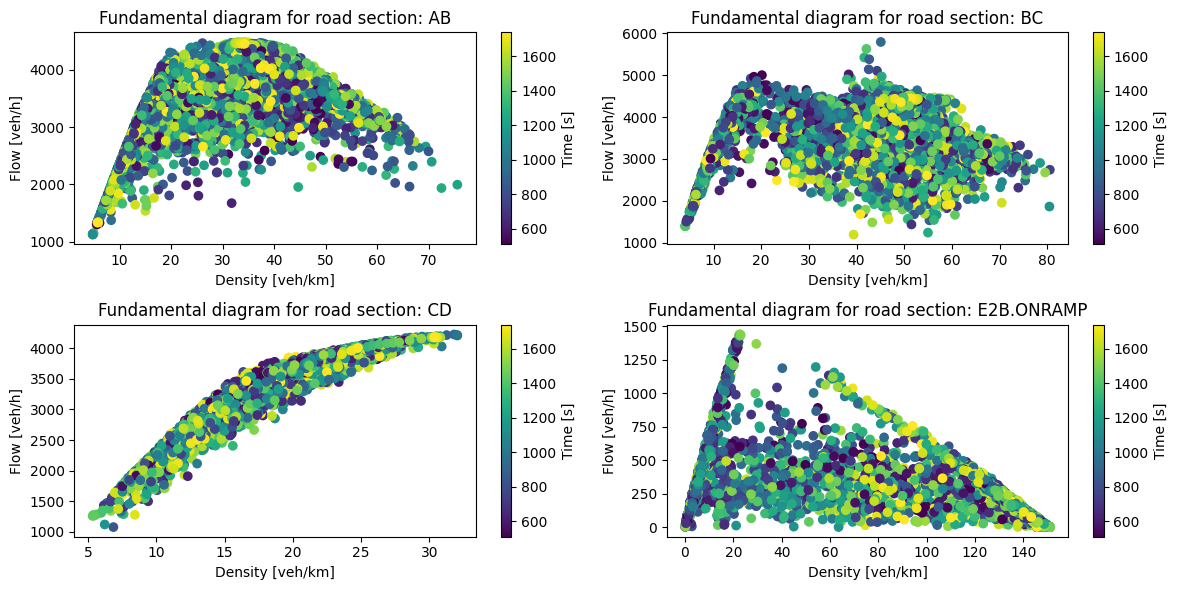

In [9]:
show_fd_scatter_plot_sections(df_new_fd, ['AB', 'BC', 'CD', 'E2B.ONRAMP'])

<b>What do we observe?</b>

The plots are based on fundamental diagram data of flow and density variables. However, also the time variable is depicted by coloring the data points in the fundamental diagram. The time variable shows that simulation runs have different traffic conditions throughout the simulation time. Taking the mean values for flow and density variables would hide much detail about the different traffic conditions. This means that the individual data points are important to consider.

The differences between the road sections can be explained as follows:
- <b>AB:</b> This is the pre-on-ramp section of the freeway consisting of a left and right lane. The diagram clearly shows the traffic consitions of free-flow, saturated traffic near the critical road capacity, and congestion.
- <b>BC:</b> This section combines the two main lanes of the freeway with the on-ramp lane (so three lanes in total). Also this diagram shows the free-flow and congested traffic very well. However, the saturated traffic flattens less gradually. This indicates that the additional flow of the on-ramp and the forced merge actions do interupt traffic. Also, much congestion is simulated for this section. This could be the case because of much congestion on the on-ramp lane, especially when we see that high flows are measured for densities between 40-50 veh/km. This would show that the two main lanes have a high flow but the onramp lane has not.
- <b>CD:</b> The post-on-ramp section has two lanes and is responsible to facilitate driving space for the outflow of the BC section. As the diagram shows, the two lanes are capable of handling the outflow of the BC section. While the curve does flattens out, no congestion occurs.
- <b>E2B.ONRAMP</b> This is the feeding lane towards the merging area of the on-ramp. As can be seen, the free-flow and congested traffic is very noticable but the near critical capacity area shows a strong capacity drop. This is expected since there is just limited space for merging vehicles. So, when they have to wait to merge into the main lanes, vehicles will stack on the on-ramp.

In [10]:
# set box limits to filter FD values
def remove_demand_non_compliant_runs(df, min_main_value, max_main_value, min_ramp_value, max_ramp_value):
    # identify runs with any data points outside the box
    non_compliant_runs = df[
        (df['main_demand'] <= min_main_value) | 
        (df['main_demand'] >= max_main_value) | 
        (df['ramp_demand'] <= min_ramp_value) | 
        (df['ramp_demand'] >= max_ramp_value)
        ][['seed', 'run']].drop_duplicates()

    # filter out these non-compliant runs from the main DataFrame
    df_filtered = df.merge(non_compliant_runs, on=['seed', 'run'], how='left', indicator=True)
    df_filtered = df_filtered[df_filtered['_merge'] == 'left_only'].drop(columns=['_merge'])
    
    # return new DataFrame
    return df_filtered

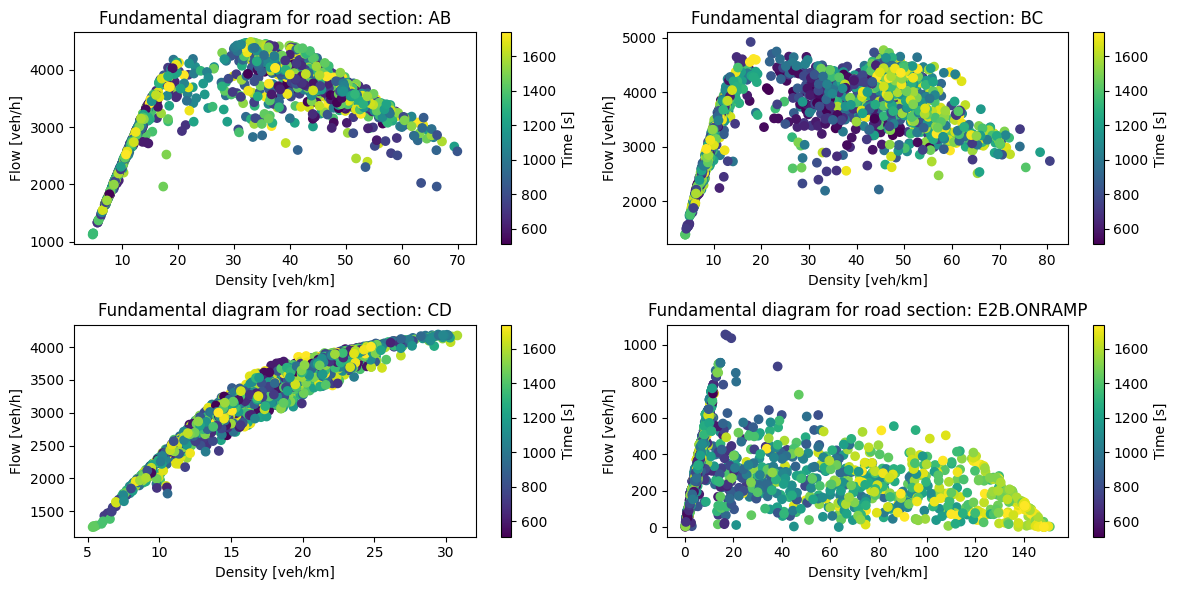

In [11]:
# show original data filtered for demand values
min_main = 1000
max_main = 6000
min_ramp = 200
max_ramp = 450
df_demand_box1 = remove_demand_non_compliant_runs(df_new_fd, min_main, max_main, min_ramp, max_ramp)

# show refined scatter plot
show_fd_scatter_plot_sections(df_demand_box1, ['AB', 'BC', 'CD', 'E2B.ONRAMP'])

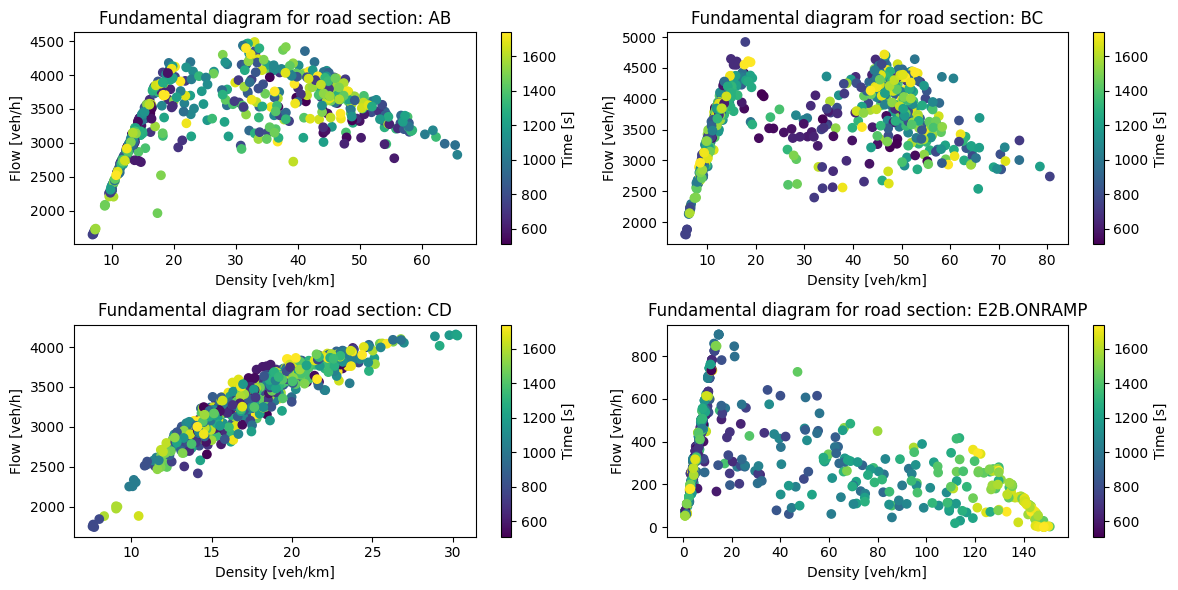

In [12]:
# show original data filtered for demand values
min_main = 2800
max_main = 4000
min_ramp = 200
max_ramp = 450
df_demand_box2 = remove_demand_non_compliant_runs(df_new_fd, min_main, max_main, min_ramp, max_ramp)

# show refined scatter plot
show_fd_scatter_plot_sections(df_demand_box2, ['AB', 'BC', 'CD', 'E2B.ONRAMP'])

<b>New demand ranges:</b>

To limit the simulation of free-flow traffic and congestion, the  demand ranges for the main lanes and on-ramp lane are reduced. However, some free-flow and congestion has to be simulated to analyse how the traffic conditions change across penetration rates of vehicle automation levels. When the ranges are too tight, it could cause the simulation to only simulate free-flow or congested traffic conditions for other scenarios.

First, the ramp demand is adjusted to lower the amount of congestion on the on-ramp. Second, the main demand is adjusted to great a suitable range for simulation of free-flow, congested, but mostly saturated traffic. When choosing a range for the on-ramp, it is also checked whether not too much data points are removed that are within the saturated traffic area.

The new selected ranges are:
- <b>Main demand:</b> 2800 - 4000 veh/h
- <b>Ramp demand:</b> 200 - 450 veh/h

This selection reduces the data points related to free-flow and congestion, see the following comparison:

Original fundamental diagrams:


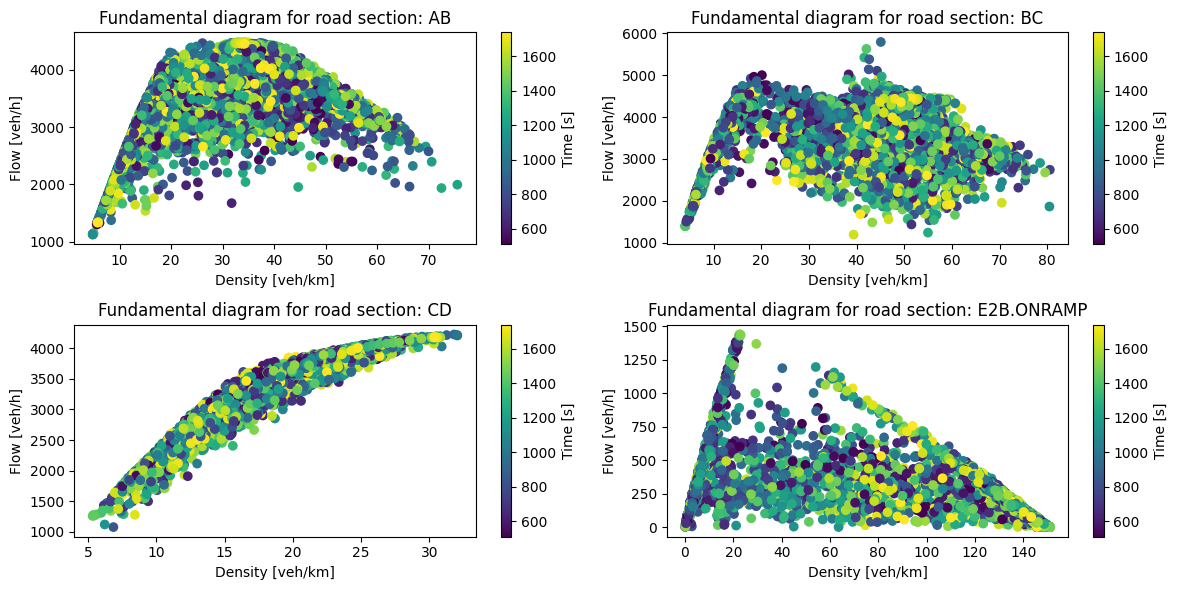

Fundamental diagrams for new demand ranges:


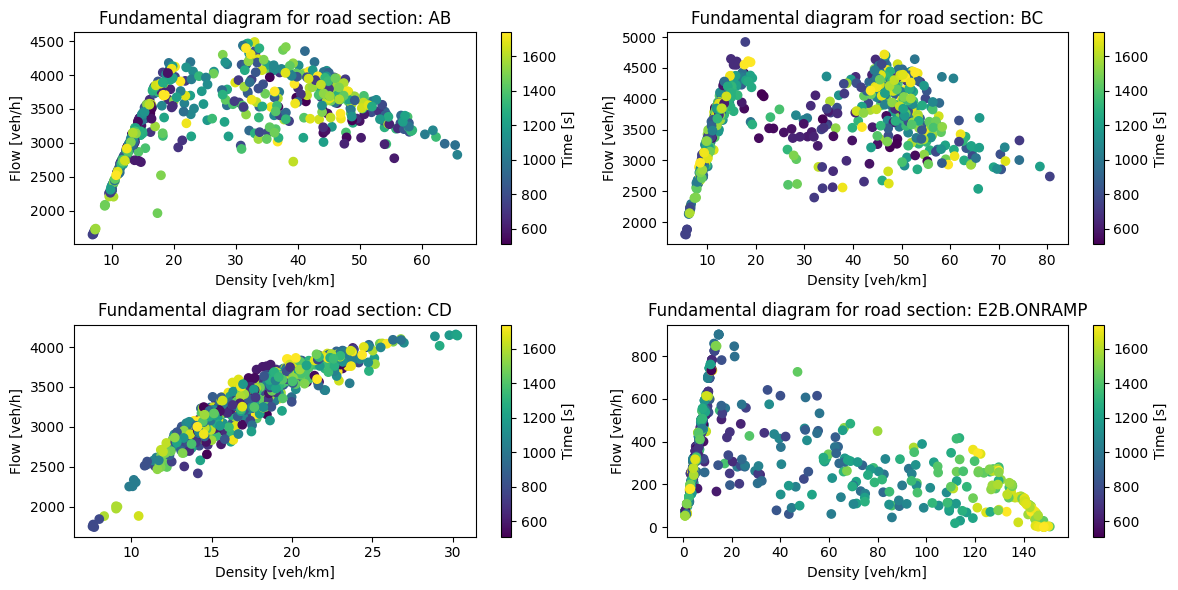

In [13]:
print('Original fundamental diagrams:')
show_fd_scatter_plot_sections(df_new_fd, ['AB', 'BC', 'CD', 'E2B.ONRAMP'])

print('Fundamental diagrams for new demand ranges:')
show_fd_scatter_plot_sections(df_demand_box2, ['AB', 'BC', 'CD', 'E2B.ONRAMP'])

The following runs comply to the selected demand ranges:

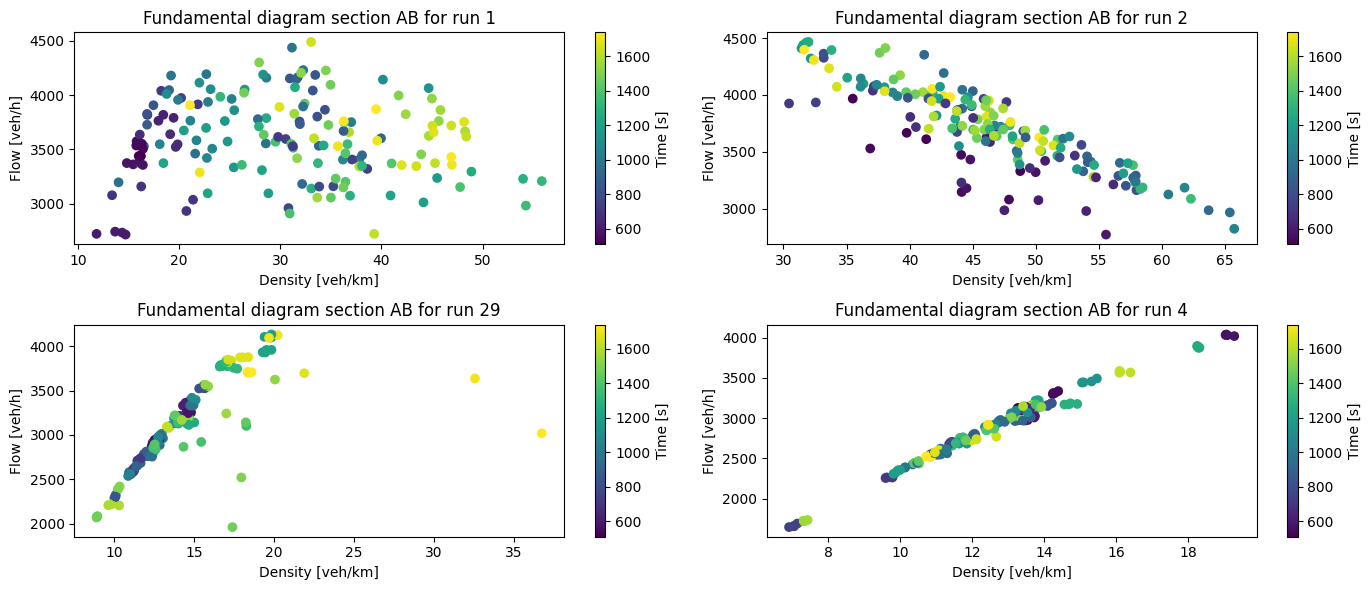

In [14]:
show_fd_scatter_plot_runs(df_demand_box2, 'AB_density', 'AB_flow')

<b>What do we see?</b>

The runs that comply to this range of values for main demand and on-ramp demand show that this range is capable of simulating all traffic conditions for the "base" scenario.

### Conclusions
This analysis shows that the simulation of human drivers does include all traffic conditions: free-flow, saturated and congestion. To identify traffic demand values that simulate all these conditions and minimize the simulation of only free-flow and congestion, new ranges are adapted for both main demand and on-ramp demand. This means that the simulation will run scenarios for the following demand values:
- <b>Main demand:</b> 2800 - 4000 veh/h
- <b>Ramp demand:</b> 200 - 450 veh/h